# What are Level Set Trees?

*DeBaCl* is a Python package for building and using **Level Set Trees (LSTs)**. As the DeBaCl readme says, these trees are most often used for:

- finding high-quality clusters with complicated distributions of data,
- understanding the shape of a dataset's distribution,
- exploratory data analysis,
- data visualization, and
- anomaly detection.

This is great, but what exactly *is* an LST? How does the method work?

## Start with data

 As usual, we start with data. For this notebook, we use 200 observations generated by the Scikit-learn "two moons" function. Although the clusters in this dataset are obvious to the naked eye, it is a relatively complicated distribution---one that cannot be well-recovered by parametric clustering methods like K-means.

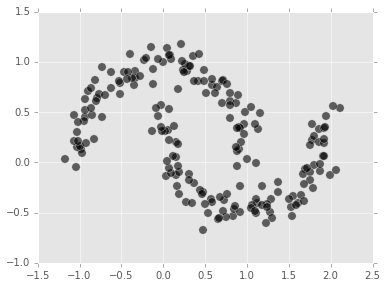

In [9]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

moons, y = make_moons(n_samples=200, noise=0.1, random_state=19)

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(moons[:, 0], moons[:, 1], c='black', s=70, alpha=0.6)
    fig.show()

## The true LST represents the true probability distribution

As a statistical method, the LST approach assumes a dataset is drawn from an unobservable probability distribution. What we would *like* to be able to do is describe the shape of the probability distribution that generated our data. This is impossible for a couple reasons, but let's work through what we *would* do if we could.

- Show contours of the true PDF (get by sampling a lot of points from `make_moons`.
- Take two upper level sets. For each one, show the region, show the topologically connected components, and observe that they would form a tree.
- Intersect the connected components with the data to get data clusters.

## *DeBaCl* estimates the true LST

### 1. Estimate the probability density at each data point

### 2. Construct a similarity graph to estimate connectivity

### 3. Filter out points in order of estimated density

### 4. As each point is removed keep track of the connected components

- Keep track of the density level where the connected component started
- Keep track of the density level where the CC splits or vanishes
- Keep track of the *mass* levels at each of these points.

### 5. Represent the LST with a dendrogram

## Resources

- PyData talk (Dato GDrive)
    - Figures and code from the talk are on **lenana:~/projects/pydata_talk**
- JSS paper submission
- Dissertation